# About this notebook

## Version 1
- PyTorch Efficientnet_b0 starter code
- 5 folds
- 30 epochs
- batch size 64 no accumulation
- Custom learning scheduler
- With data augmentation

## Version 2
- PyTorch Efficientnet_b0 starter code
- 5 folds
- 30 epochs
- batch size 64 no accumulation
- Custom learning scheduler
- With data augmentation
- Focal loss
- meta features 'Age' 'variety'

# Improvements maybe
- Use ArcFace or add triplet loss with cross entropy for accuracy improvement
- Use meta featues 'Age' 'variety' to improove the performance of the models
- Use focal Loss (already implemented)

# acknowledgement
- Y.NAKAMA great [notebook](https://www.kaggle.com/yasufuminakama/herbarium-2020-pytorch-resnet18-train/notebook)

If this notebook is helpful, feel free to upvote :)

### Set Kaggle API and Download the Data

In [ ]:
!pip install kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

In [ ]:
#!kaggle competitions download -c paddy-disease-classification

In [ ]:
!pip install timm
!pip install albumentations==0.4.6
!pip install iterative-stratification

In [1]:
import os
import gc
import numpy as np
import pandas as pd
from PIL import Image
import cv2 as cv
from matplotlib import pyplot as plt
import seaborn as sns

pd.options.display.max_columns = 300

# Quick EDA

In [2]:
train_df = pd.read_csv('train.csv')

submission = pd.read_csv('sample_submission.csv')
train_dir = 'train_images'

In [4]:
train_df['path_jpeg'] = train_df.apply(lambda row: os.path.join(train_dir , row['label'] , row['image_id']), axis=1)

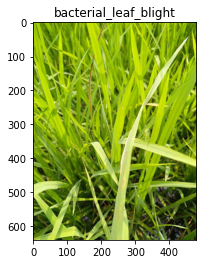

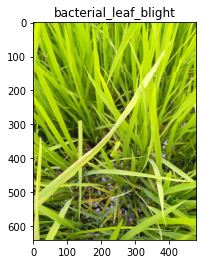

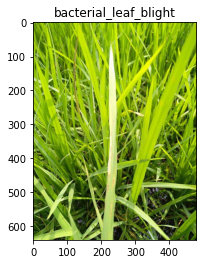

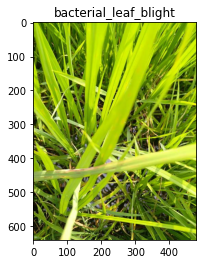

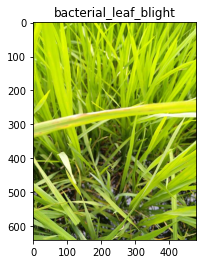

In [6]:
for i in range(5):
    image = cv.imread(train_df.loc[i, 'path_jpeg'])
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    label = train_df.loc[i, 'label']
    plt.imshow(image)
    plt.title(f"{label}")
    plt.show()

In [7]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(train_df['label'])
train_df['label'] = le.transform(train_df['label'])

In [8]:
le.fit(train_df['variety'])
train_df['variety'] = le.transform(train_df['variety'])

# Directory settings

In [9]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Configuration

In [10]:
class CFG:
    apex=False
    debug=False
    print_freq=100
    size=384
    num_workers=2
    scheduler='CosineAnnealingLR' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts','OneCycleLR']
    epochs=40
    # CosineAnnealingLR params
    cosanneal_params={
        'T_max':10,
        'eta_min':1e-4*0.5,
        'last_epoch':-1
    }
    #ReduceLROnPlateau params
    reduce_params={
        'mode':'min',
        'factor':0.2,
        'patience':5,
        'eps':1e-6,
        'verbose':True
    }
    # CosineAnnealingWarmRestarts params
    cosanneal_res_params={
        'T_0':10,
        'eta_min':1e-6,
        'T_mult':1,
        'last_epoch':-1
    }
    # OneCycleLR params
    onecycle_params={
        'pct_start':0.1,
        'div_factor':1e1,
        'max_lr':1e-3,
        'steps_per_epoch':3, 
        'epochs':3
    }
    #batch_size=64
    momentum=0.9
    lr=1e-3
    weight_decay=1e-4
    gradient_accumulation_steps=1
    max_grad_norm=1000
    nfolds=5
    trn_folds=[0, 1, 2, 3, 4]
    model_name='tf_efficientnetv2_b0'     #'vit_base_patch32_224_in21k' 'tf_efficientnetv2_b0' 'resnext50_32x4d' 'resnet50d' 'efficientnet_b0'
    preds_col = ['bacterial_leaf_blight', 'bacterial_leaf_streak',
               'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart',
               'downy_mildew', 'hispa', 'normal', 'tungro']
    train=True
    early_stop=True
    target_size=len(preds_col)
    scale=30.0
    margin=0.50
    easy_margin=False
    ls_eps=0.0
    fc_dim=512
    early_stopping_steps=5
    grad_cam=False
    seed=2022

    batch_size = 64
    #batch_size = 8
    smoothing=0.05
    t1=0.3 # bi-tempered-loss https://www.kaggle.com/c/cassava-leaf-disease-classification/discussion/202017
    t2=1.0 # bi-tempered-loss https://www.kaggle.com/c/cassava-leaf-disease-classification/discussion/202017

In [11]:
# ====================================================
# Library
# ====================================================
import sys
import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
from torch.cuda import amp

import scipy as sp
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image
from PIL import ImageFile
# sometimes, you will have images without an ending bit
# this takes care of those kind of (corrupt) images
ImageFile.LOAD_TRUNCATED_IMAGES = True
import albumentations as A 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.optim.optimizer import Optimizer
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

import albumentations as A
from torchvision import transforms ,datasets
from torchvision.utils import make_grid
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform
from albumentations import (ToFloat, Normalize, VerticalFlip, HorizontalFlip, Compose, Resize,
                            RandomBrightnessContrast, HueSaturationValue, Blur, GaussNoise,
                            Rotate, RandomResizedCrop, Cutout, ShiftScaleRotate)


import timm

from torch.cuda.amp import autocast, GradScaler

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
VERSION = 1

# Utils

In [12]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = log_loss(y_true, y_pred)
    return score

def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def set_seed(seed = 2022):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed()

# CV schem

In [13]:
%%time
skf = MultilabelStratifiedKFold(n_splits=CFG.nfolds, shuffle=True, random_state=CFG.seed)
for fold, (trn_idx, vld_idx) in enumerate(skf.split(train_df, train_df[['label', 'age', 'variety']])):
    train_df.loc[vld_idx, "fold"] = int(fold)
train_df["fold"] = train_df["fold"].astype(int)

CPU times: total: 453 ms
Wall time: 489 ms


# Dataset

In [14]:
class classificationDataset:
    def __init__(self,dataframe ,image_paths, targets ,resize=None, augmentations=None):

        self.dataframe = dataframe
        self.image_paths = image_paths
        self.targets = targets
        self.resize = resize
        self.augmentations = augmentations
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, item):
        
        image = Image.open(self.image_paths[item])
        targets = self.targets[item]
        csv_data = np.array(self.dataframe.iloc[item][['variety','age']].values, dtype=np.float32)
        
        if self.resize is not None:
            image = image.resize(
                (self.resize[1], self.resize[0]), resample=Image.BILINEAR
            )
            
        image = np.array(image)
        
        if self.augmentations is not None:
            augmented = self.augmentations(image=image)
            image = augmented["image"]

            
        return image, np.array(csv_data) , torch.tensor(targets)

# Transforms

In [15]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):
    
    if data == 'train':
        return A.Compose(
        [
           A.Resize(CFG.size, CFG.size),
           A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            A.Flip(p=0.5),
            
            #A.Cutout(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Rotate(limit=180, p=0.5),
            A.ShiftScaleRotate(
                shift_limit = 0.1, scale_limit=0.1, rotate_limit=45, p=0.5
            ),
           
            ToTensorV2(p=1.0),
        ]
    )


    elif data == 'valid':
        return A.Compose([
            A.Resize(CFG.size, CFG.size),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

In [16]:
train_folds = train_df[train_df['fold'] != 0]
train_images_path = train_folds.path_jpeg.values
train_targets = train_folds.label.values

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


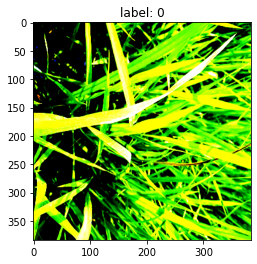

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


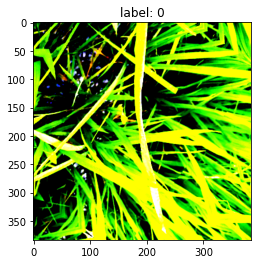

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


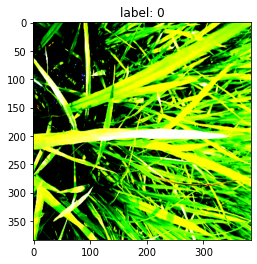

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


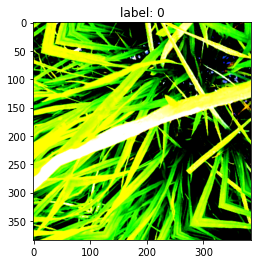

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


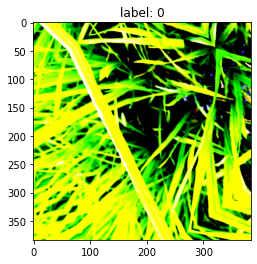

In [17]:
train_dataset = classificationDataset(dataframe=train_folds,
                                image_paths=train_images_path,
                                targets=train_targets,
                                augmentations=get_transforms(data='train'))
for i in range(5):
    plt.figure(figsize=(4, 4))
    image1,csv_data ,label = train_dataset[i]
    plt.imshow(image1.permute(2,1,0))
    plt.title(f'label: {label}')
    plt.show() 

# Model

In [18]:
class Swish(torch.autograd.Function):

    @staticmethod
    def forward(ctx, i):
        result = i * torch.sigmoid(i)
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_variables[0]
        sigmoid_i = torch.sigmoid(i)
        return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))


class Swish_module(nn.Module):
    def forward(self, x):
        return Swish.apply(x)

In [19]:
class CrossEntropyLossWithLabelSmoothing(nn.Module):
    def __init__(self, n_dim, ls_=0.9):
        super().__init__()
        self.n_dim = n_dim
        self.ls_ = ls_

    def forward(self, x, target):
        target = F.one_hot(target, self.n_dim).float()
        target *= self.ls_
        target += (1 - self.ls_) / self.n_dim

        logprobs = torch.nn.functional.log_softmax(x, dim=-1)
        loss = -logprobs * target
        loss = loss.sum(-1)
        return loss.mean()


class DenseCrossEntropy(nn.Module):
    def forward(self, x, target):
        x = x.float()
        target = target.float()
        logprobs = torch.nn.functional.log_softmax(x, dim=-1)

        loss = -logprobs * target
        loss = loss.sum(-1)
        return loss.mean()



In [20]:
class ArcMarginProduct_subcenter(nn.Module):
    def __init__(self, in_features, out_features, k=3):
        super().__init__()
        self.weight = nn.Parameter(torch.FloatTensor(out_features*k, in_features))
        self.reset_parameters()
        self.k = k
        self.out_features = out_features
        
    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        
    def forward(self, features):
        cosine_all = F.linear(F.normalize(features), F.normalize(self.weight))
        cosine_all = cosine_all.view(-1, self.out_features, self.k)
        cosine, _ = torch.max(cosine_all, dim=2)
        return cosine

class ArcFaceLossAdaptiveMargin(nn.modules.Module):
    def __init__(self, margins, s=30.0):
        super().__init__()
        self.crit = DenseCrossEntropy()
        self.s = s
        self.margins = margins
            
    def forward(self, logits, labels, out_dim):
        ms = []
        ms = self.margins[labels.cpu().numpy()]
        cos_m = torch.from_numpy(np.cos(ms)).float().cuda()
        sin_m = torch.from_numpy(np.sin(ms)).float().cuda()
        th = torch.from_numpy(np.cos(math.pi - ms)).float().cuda()
        mm = torch.from_numpy(np.sin(math.pi - ms) * ms).float().cuda()
        labels = F.one_hot(labels, out_dim).float()
        logits = logits.float()
        cosine = logits
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * cos_m.view(-1,1) - sine * sin_m.view(-1,1)
        phi = torch.where(cosine > th.view(-1,1), phi, cosine - mm.view(-1,1))
        output = (labels * phi) + ((1.0 - labels) * cosine)
        output *= self.s
        loss = self.crit(output, labels)
        return loss     

In [21]:
# ====================================================
# MODEL
# ====================================================
class Effnet_Landmark(nn.Module):

    def __init__(self, enet_type, out_dim):
        super(Effnet_Landmark, self).__init__()
        self.enet =timm.create_model(enet_type, pretrained=True)
        self.feat = nn.Linear(self.enet.classifier.in_features, 512)
        self.swish = Swish_module()
        self.metric_classify = ArcMarginProduct_subcenter(512, out_dim)
        self.enet.classifier = nn.Identity()

    def extract(self, x):
        return self.enet(x)

    def forward(self, x):
        x = self.extract(x)
        logits_m = self.metric_classify(self.swish(self.feat(x)))
        return logits_m

In [22]:
# get adaptive margin
tmp = np.sqrt(1 / np.sqrt(train_df.label.value_counts().sort_index().values))
margins = (tmp - tmp.min()) / (tmp.max() - tmp.min()) * 0.45 + 0.05

In [23]:
def ARC_criterion(logits_m, target):
    arc = ArcFaceLossAdaptiveMargin(margins=margins, s=30.0)
    loss_m = arc(logits_m, target, CFG.target_size)
    return loss_m

In [24]:
# images = torch.rand([5, 3, 256, 256])
# labels = torch.rand([5])
# csv_data = torch.rand([5, 2])
# images = images.to(device)
# csv_data = csv_data.to(device)
# labels = labels.to(device)

In [25]:
# arcmodel = Effnet_Landmark(CFG.model_name, CFG.target_size)
# arcmodel.to(device)
# arcmodel(images)

# Helper functions

In [26]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, optimizer, epoch, scheduler, device):
    if CFG.apex:
        scaler = GradScaler()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images,_, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device).float()
        labels = labels.to(device).long()
        batch_size = labels.size(0)
        if CFG.apex:
            with autocast():
                probs, arcface = model(images, labels)
                arcface_loss = nn.CrossEntropyLoss()(arcface, labels)
                #loss = criterion(probs, labels)
        else:
            probs = model(images)
            arcface_loss = ARC_criterion(probs, labels)
            #loss = criterion(probs, labels)
        # record loss
        sum_loss = arcface_loss
        losses.update(sum_loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            sum_loss = sum_loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            scaler.scale(sum_loss).backward()
        else:
            sum_loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            if CFG.apex:
                scaler.step(optimizer)
                scaler.update()
            else:
                optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f} '
                  'LR: {lr:.6f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images,_, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device).float()
        labels = labels.to(device).long()
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            probs = model(images)
        preds.append(probs.softmax(1).to('cpu').numpy())
        loss = criterion(probs, labels)
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    return losses.avg, predictions

# Train loop

In [27]:
# ====================================================
# Train loop
# ====================================================

def train_loop(folds, fold):
    scaler = amp.GradScaler()
    LOGGER.info(f"========== fold: {fold} training ==========")
    
    if CFG.debug:
        train_folds = folds[folds['fold'] != fold].sample(50)
        valid_folds = folds[folds['fold'] == fold].sample(50)
        
    else:
        train_folds = folds[folds['fold'] != fold]
        valid_folds = folds[folds['fold'] == fold]
        
        
    train_images_path = train_folds.path_jpeg.values
    train_targets = train_folds.label.values
        
    valid_images_path = valid_folds.path_jpeg.values
    valid_targets = valid_folds.label.values
        
    train_dataset = classificationDataset(dataframe=train_folds,
                                image_paths=train_images_path,
                                targets=train_targets,
                                augmentations=get_transforms(data='train'))
        
    valid_dataset = classificationDataset(dataframe=valid_folds,
                                image_paths=valid_images_path,
                                targets=valid_targets,
                                augmentations=get_transforms(data='valid'))
        
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=CFG.batch_size, shuffle=True
    )
        
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=CFG.batch_size, shuffle=False
    )
    
    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, **CFG.reduce_params)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, **CFG.cosanneal_params)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, **CFG.cosanneal_res_params)
        return scheduler
    
    # ====================================================
    # model & optimizer
    # ====================================================
        
    model = Effnet_Landmark(CFG.model_name, CFG.target_size)
    model.to(device)

    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.CrossEntropyLoss()

    best_loss = np.inf
    best_acc = -np.inf
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(fold, train_loader, model, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

        # scoring
        
        preds_label = np.argmax(preds, axis=1)
        Accuracy = accuracy_score(preds_label, valid_targets)
        score = get_score(valid_targets, preds)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        LOGGER.info(f'Epoch {epoch+1} - Accuracy: {Accuracy:.4f}')

            
        if Accuracy > best_acc:
            best_acc = Accuracy
            LOGGER.info(f'Epoch {epoch+1} - Save Best Accuracy: {best_acc:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds_loss': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_Accuracy.pth')
            

        
        
    valid_folds[CFG.preds_col] = torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_Accuracy.pth', 
                                      map_location=torch.device('cpu'))['preds_loss']

    return valid_folds

In [28]:
# ====================================================
# main
# ====================================================
def main():

    """
    Prepare: 1.train 
    """

    def get_result(result_df):
        preds_loss = result_df[CFG.preds_col].values
        labels = result_df["label"].values
        preds = np.argmax(preds_loss, axis=1)
        Accuracy = accuracy_score(labels, preds)
        LOGGER.info(f'Accuracy with best weights: {Accuracy:<.4f}')
    
    if CFG.train:
        # train 
        oof_df = pd.DataFrame()
        for fold in range(CFG.nfolds):
            if fold in CFG.trn_folds:
                _oof_df = train_loop(train_df, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        # save result
        oof_df[['image_id','bacterial_leaf_blight', 'bacterial_leaf_streak',
       'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart',
       'downy_mildew', 'hispa', 'normal', 'tungro','label']].to_csv(OUTPUT_DIR+f'{CFG.model_name}_oof_rgb_df_version{VERSION}.csv', index=False)
        

In [29]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [30]:
if __name__ == "__main__":
    main()

========== fold: 0 training ==========


Epoch: [1][0/7] Elapsed 0m 5s (remain 0m 32s) Loss: 5.5094(5.5094) Grad: 42.6885 LR: 0.001000  
Epoch: [1][6/7] Elapsed 0m 7s (remain 0m 0s) Loss: 2.4143(8.0217) Grad: 52.1094 LR: 0.001000  
EVAL: [0/7] Elapsed 0m 0s (remain 0m 1s) Loss: 2.2346(2.2346) 


Epoch 1 - avg_train_loss: 8.0217  avg_val_loss: 2.2867  time: 9s
Epoch 1 - Score: 2.2867
Epoch 1 - Accuracy: 0.1000
Epoch 1 - Save Best Accuracy: 0.1000 Model


EVAL: [6/7] Elapsed 0m 1s (remain 0m 0s) Loss: 2.1905(2.2867) 
Epoch: [2][0/7] Elapsed 0m 0s (remain 0m 1s) Loss: 5.3959(5.3959) Grad: 32.2621 LR: 0.000954  
Epoch: [2][6/7] Elapsed 0m 2s (remain 0m 0s) Loss: 8.4032(5.1213) Grad: 40.4836 LR: 0.000954  
EVAL: [0/7] Elapsed 0m 0s (remain 0m 0s) Loss: 2.2339(2.2339) 


Epoch 2 - avg_train_loss: 5.1213  avg_val_loss: 2.2603  time: 3s
Epoch 2 - Score: 2.2603
Epoch 2 - Accuracy: 0.2200
Epoch 2 - Save Best Accuracy: 0.2200 Model


EVAL: [6/7] Elapsed 0m 0s (remain 0m 0s) Loss: 2.2482(2.2603) 
Epoch: [3][0/7] Elapsed 0m 0s (remain 0m 1s) Loss: 1.0826(1.0826) Grad: 24.7453 LR: 0.000847  
Epoch: [3][6/7] Elapsed 0m 2s (remain 0m 0s) Loss: 2.1179(4.7191) Grad: 107.7606 LR: 0.000847  
EVAL: [0/7] Elapsed 0m 0s (remain 0m 0s) Loss: 2.1803(2.1803) 


Epoch 3 - avg_train_loss: 4.7191  avg_val_loss: 2.2590  time: 3s
Epoch 3 - Score: 2.2590
Epoch 3 - Accuracy: 0.2800
Epoch 3 - Save Best Accuracy: 0.2800 Model


EVAL: [6/7] Elapsed 0m 0s (remain 0m 0s) Loss: 2.2581(2.2590) 
Epoch: [4][0/7] Elapsed 0m 0s (remain 0m 1s) Loss: 6.1813(6.1813) Grad: 31.6539 LR: 0.000712  
Epoch: [4][6/7] Elapsed 0m 2s (remain 0m 0s) Loss: 1.3599(3.4505) Grad: 28.3913 LR: 0.000712  
EVAL: [0/7] Elapsed 0m 0s (remain 0m 1s) Loss: 2.2098(2.2098) 


Epoch 4 - avg_train_loss: 3.4505  avg_val_loss: 2.2762  time: 3s
Epoch 4 - Score: 2.2762
Epoch 4 - Accuracy: 0.2200


EVAL: [6/7] Elapsed 0m 1s (remain 0m 0s) Loss: 2.2241(2.2762) 
Epoch: [5][0/7] Elapsed 0m 0s (remain 0m 1s) Loss: 2.0033(2.0033) Grad: 22.6544 LR: 0.000563  


KeyboardInterrupt: 